In [2]:
from data_process import get_data_loaders, getFeatures
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
data = pd.read_csv('flights.csv')
# flights_to_remove = [211,212,213,214,215,216,217,218,219]
# data = data[~data['flight'].isin(flights_to_remove)]
# data['power'] = data['battery_voltage'] * data['battery_current']
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
# data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
#                                                                         features=select_features, covariates=False)
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                                        features=None, covariates=False)

In [52]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 32])
torch.Size([64, 10])


In [14]:
def parse_altitude(altitude_str):
    altitude_str = str(altitude_str)
    altitudes = [int(alt) for alt in altitude_str.split('-')]
    max_altitude = max(altitudes)
    min_altitude = min(altitudes)
    mean_altitude = sum(altitudes) / len(altitudes)
    return pd.Series([max_altitude, min_altitude, mean_altitude], index=['max_altitude', 'min_altitude', 'mean_altitude'])

altitude_features = data['altitude'].apply(parse_altitude)
data = data.join(altitude_features)

In [48]:
flight_num = 276
flight_data = data[data['flight'] == flight_num]
# flight_data = data.copy(deep=True)
# flight_data['delta_power'] = flight_data['power'].diff()
flight_data['delta_x'] = flight_data['position_x'].diff()
flight_data['delta_y'] = flight_data['position_y'].diff()
flight_data['delta_z'] = flight_data['position_z'].diff()
flight_data['travel_dist'] = flight_data['delta_x']**2 + flight_data['delta_y']**2 + flight_data['delta_z']**2

# flight_data = flight_data[abs(flight_data['delta_x']) < 0.1]

# plt.scatter(flight_data['delta_x'], flight_data['delta_power'], s=1)


In [40]:
cols = data.columns.to_list()
x_cols = [n for n in cols if n not in ['time_diff', 'flight', 'power', 'time', 'date', 'time_day', 'altitude', 'route', 'battery_current', 'battery_voltage']]
y_cols = ['power']

In [49]:
# linear regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

X = flight_data[x_cols].values.reshape(-1, len(x_cols))
y = flight_data[y_cols].values.reshape(-1, len(y_cols))

print(X.shape, y.shape)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)
reg = Ridge()
reg.fit(X_train, y_train)

(984, 27) (984, 1)


Ridge()

<BarContainer object of 27 artists>

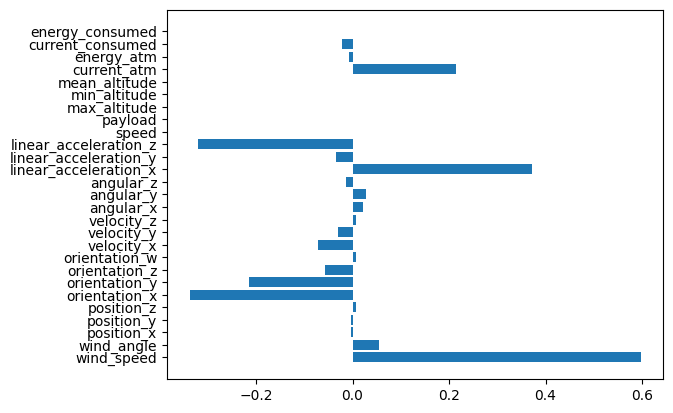

In [50]:
coef = reg.coef_
plt.barh(x_cols, coef[0])